In [1]:
import ionerdss as ion

pdb_id = '8y7s' # PDB ID for the structure of interest, or the full path to a PDB file
save_folder = '~/Documents/8y7s_dir' # the working directory

# create the PDBModel object using the PDBModel class
pdb_model = ion.PDBModel(pdb_id=pdb_id, save_dir=save_folder)

# coarse grain each chain of the PDB structure to a NERDSS molecule
# set standard_output=True to see the determined interfaces
pdb_model.coarse_grain(
    distance_cutoff=0.35,
    residue_cutoff=3,
    show_coarse_grained_structure=False,
    save_pymol_script=False,
    standard_output=False
    )

# regularize homologous chains to the same NERDSS molecule type
pdb_model.regularize_homologous_chains(
    dist_threshold_intra=3.5,
    dist_threshold_inter=3.5,
    angle_threshold=25.0,
    show_coarse_grained_structure=False,
    save_pymol_script=True,
    standard_output=False
    )

Successfully downloaded assembly file: /Users/yueying/Documents/8y7s_dir/8y7s-assembly1.cif.gz
Homologous chains identified using sequence alignment:
{'B': 'A', 'A': 'A', 'E': 'A', 'F': 'A'}
Homologous chain groups identified:
[['A', 'B', 'E', 'F']]
Regularized coarse-grained structure saved to /Users/yueying/Documents/8y7s_dir/regularized_coarse_grained_structure.cif.
PyMOL script saved to /Users/yueying/Documents/8y7s_dir/visualize_regularized_coarse_grained.pml.
Model saved successfully to /Users/yueying/Documents/8y7s_dir/8y7s_model.json


In [8]:
pdb_model.reactions[0].ka = 1200
pdb_model.reactions[1].ka = 1200
pdb_model.reactions[2].ka = 1200
pdb_model.reactions[0].kb = 798
pdb_model.reactions[1].kb = 47.4
pdb_model.reactions[2].kb = 533

Saved assembly_data.json


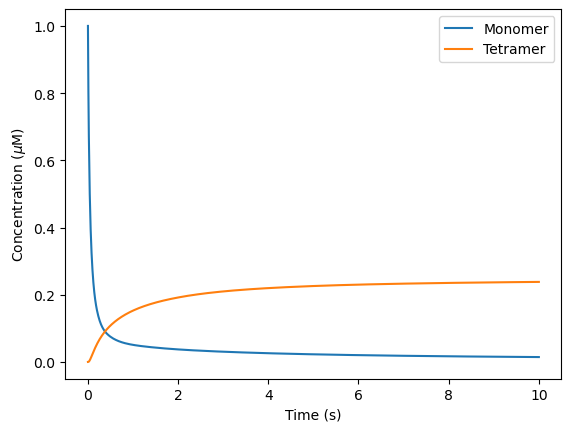

In [12]:
from ionerdss import ParseComplexes
from ionerdss import ReactionStringParser
from ionerdss import solve_reaction_ode, reaction_dydt
import numpy as np

complex_list, complex_reaction_system = ParseComplexes(pdb_model)

# initialize an instance of reaction_string_parser
rsp = ReactionStringParser()

reaction_strings = [reaction.expression for reaction in complex_reaction_system.reactions]
species_names, rate_constant_names, reactant_matrix, product_matrix = rsp.parse_reaction_strings(reaction_strings)

# Rate constant assuming already non-dimensionalized
rate_constants = [reaction.rate for reaction in complex_reaction_system.reactions]

# Define time span and initial concentration, assuming already non-dimensionalized
t_span = [0.0, 10.0]
y_init = np.zeros(len(complex_list)) # initial concentration
y_init[0] = 1.0 # initial monomer concentration

time, concentrations, species_names = solve_reaction_ode(
    reaction_dydt, t_span,  y_init, reactant_matrix = reactant_matrix, product_matrix = product_matrix,
    k = rate_constants, plotting=False, method = "BDF", species_names = species_names
    )

import matplotlib.pyplot as plt

plt.plot(time,((concentrations.T)[0]).T, label='Monomer')
# Plotting the concentrations of Tetramer, sum of 1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,24
indices = [1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,24]
plt.plot(time,((concentrations.T)[indices]).T.sum(axis=1), label='Tetramer')

import json
# Compute monomer
monomer = concentrations[:, 0]

# Compute tetramer sum
indices = [1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,24]
tetramer = concentrations[:, indices].sum(axis=1)
# Convert numpy arrays to Python lists for JSON serialization
data_dict = {
    "time": time.tolist(),
    "monomer": monomer.tolist(),
    "tetramer": tetramer.tolist(),
    "indices_used_for_tetramer": indices
}

# Save to JSON file
with open("8y7s_assembly_data.json", "w") as f:
    json.dump(data_dict, f, indent=2)

print("Saved assembly_data.json")

plt.xlabel('Time (s)')
plt.ylabel(r'Concentration $\left(\mu\mathrm{M}\right)$')
plt.legend()

In [13]:
# create the Simulation object using the Simulation class
# the simulation is connected to the PDBModel object created above
simulation = ion.Simulation(pdb_model, save_folder)

# generate the NERDSS input files for the simulation
simulation.generate_nerdss_input()

simulation.modify_inp_file(
    {'nItr': 20000000, 'timeStep': 0.5,
    'timeWrite': 20000, 'trajWrite': 2000000,
    'pdbWrite': 2000000, 'A': 130,
    'WaterBox': [600.0, 600.0, 600.0]}
    )

simulation.print_inp_file()

# install NERDSS if not already installed
simulation.install_nerdss(nerdss_path="~/Documents/8y7s_dir")

# run the NERDSS simulation
simulation.run_new_simulations(
    sim_indices=[1],
    sim_dir="~/Documents/8y7s_dir/nerdss_output",
    nerdss_dir="~/Documents/8y7s_dir/NERDSS",
    parallel=False
    )

Working directory set to: /Users/yueying/Documents/8y7s_dir
start parameters
	nItr = 20000000
	timeStep = 0.5
	timeWrite = 20000
	trajWrite = 2000000
	pdbWrite = 2000000
	restartWrite = 100000
	checkPoint = 100000
	transitionWrite = 100000
	clusterOverlapCheck = false
	scaleMaxDisplace = 100.0
	overlapSepLimit = 0.1
end parameters

start boundaries
	WaterBox = [600.0, 600.0, 600.0]
	hasCompartment = false
	compartmentR = 0
	compartmentSiteD = 0
	compartmentSiteRho = 0
	WaterBox = [600.0, 600.0, 600.0]
end boundaries

start molecules
	A : 130
end molecules

start reactions
	A(A1) + A(A1) <-> A(A1!1).A(A1!1)
		onRate3Dka = 1200
		offRatekb = 798
		sigma = 0.49760597944259644
		norm1 = [0, 0, 1]
		norm2 = [0, 0, 1]
		assocAngles = [2.529533, 2.558965, 0.772629, 0.752809, 0.969040]
		length3Dto2D = 2.0
		bindRadSameCom = 1.5
		loopCoopFactor = 1.0
		excludeVolumeBound = False

	A(A2) + A(A2) <-> A(A2!1).A(A2!1)
		onRate3Dka = 1200
		offRatekb = 47.4
		sigma = 0.7669278979301453
		norm1 = [

Cloning into '/Users/yueying/Documents/8y7s_dir/NERDSS'...
==> Auto-updating Homebrew...
Adjust how often this is run with `$HOMEBREW_AUTO_UPDATE_SECS` or disable with
`$HOMEBREW_NO_AUTO_UPDATE=1`. Hide these hints with `$HOMEBREW_NO_ENV_HINTS=1` (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/core/portable-ruby/blobs/sha256:c6946ba2c387b47934e77c352c2056489421003ec7ddb2abf246cef2168ec140
######################################################################## 100.0%
==> Pouring portable-ruby-3.4.7.arm64_big_sur.bottle.tar.gz
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
aicommit2: Reactive CLI that generates commit messages for Git and Jujutsu with AI
airtable-mcp-server: MCP Server for Airtable
aklomp-base64: Fast Base64 stream encoder/decoder in C99, with SIMD acceleration
ansible@12: Automate deployment, configuration, and upgrading
archgw: CLI for Arch Gateway
asm-lsp: Language server for NASM/GAS/GO Assembly
atomic_que

Compiling src/boundary_conditions/check_if_spans.cpp to obj/boundary_conditions/check_if_spans.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/boundary_conditions/check_if_spans.cpp -o obj/boundary_conditions/check_if_spans.o  
------------
Compiling src/boundary_conditions/check_if_spans_box.cpp to obj/boundary_conditions/check_if_spans_box.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/boundary_conditions/check_if_spans_box.cpp -o obj/boundary_conditions/check_if_spans_box.o  
------------
Compiling src/boundary_conditions/check_if_spans_sphere.cpp to obj/boundary_conditions/check_if_spans_sphere.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/boundary_conditions/check_if_spans_sphere.cpp -o obj/boundary_conditions/check_if_spans_sphere.o  
------------
Compiling src/boundary_conditions/reflect_complex_compartment.cpp to obj/boundary_conditions/reflect_complex_compartment.o
g++ -O3  -std=c++

ld: warning: ignoring file /opt/homebrew/Cellar/gsl/2.8/lib/libgsl.dylib, building for macOS-x86_64 but attempting to link with file built for macOS-arm64
ld: warning: ignoring file /opt/homebrew/Cellar/gsl/2.8/lib/libgslcblas.dylib, building for macOS-x86_64 but attempting to link with file built for macOS-arm64
Undefined symbols for architecture x86_64:
  "_gsl_integration_qag", referenced from:
      integrator(gsl_function_struct, IntegrandParams, gsl_integration_workspace*, double, double, double, double, double, char*, double (*)(double, void*)) in integrator.o
  "_gsl_integration_qagiu", referenced from:
      create_normMatrix(gsl_matrix*&, double, double, double, double, double, Parameters const&) in create_normMatrix.o
      integral_for_blockdistance2D(paramsIL&) in functions_implicitlipid.o
      pimplicitlipid_2D(paramsIL&) in functions_implicitlipid.o
      integrator(gsl_function_struct, IntegrandParams, gsl_integration_workspace*, double, double, double, double, double,

FileNotFoundError: NERDSS executable not found at /Users/yueying/Documents/8y7s_dir/NERDSS/bin/nerdss. Make sure it is installed and compiled.

Detected a batch of 1 simulation directories.
Plotting line with:
- x-axis: time
- y-axis: count
- z-axis: None
- Simulations: 1 selected
- Legend: ['A: 1.', 'A: 4.']
- Display mode: average
Processed data saved to /Users/sikao/Documents/8y7s_dir/nerdss_output/figure_plot_data/complex_count_vs_time.csv
Plot saved to /Users/sikao/Documents/8y7s_dir/nerdss_output/figure_plot_data/complex_count_vs_time.svg


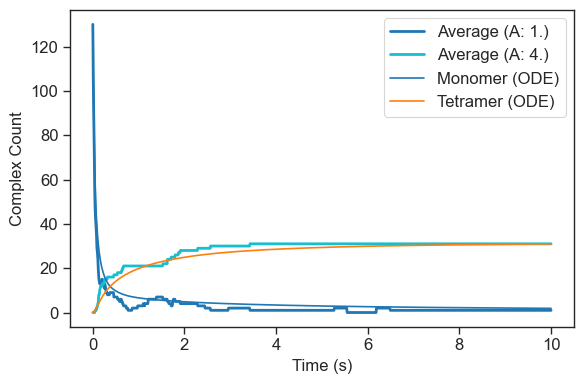

In [5]:
# create the Analysis object using the Analysis class
# the nerdss_output directory is the output directory from the NERDSS simulation
# it can be the parent directory of several simulations
analysis = ion.Analysis("~/Documents/8y7s_dir/nerdss_output")

analysis.plot_figure(
    figure_type='line',
    x='time',
    y='count',
    legend=["A: 1.", "A: 4.",],
    show_type='average',
    figure_size = (6, 4)
    )

plt.plot(time,((concentrations.T)[0]).T * 130, label='Monomer (ODE)')
# Plotting the concentrations of Tetramer, sum of 1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,24
indices = [1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,24]
plt.plot(time,((concentrations.T)[indices]).T.sum(axis=1) * 130, label='Tetramer (ODE)')

plt.legend()